In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 加载数据
df = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')

# 查看数据基本信息
print(f"数据行数: {df.shape[0]}")
print(f"数据列数: {df.shape[1]}")
print("\n前5行数据示例:")
print(df.head())


数据行数: 119390
数据列数: 32

前5行数据示例:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0     

In [2]:
# 检查缺失值
missing_values = df.isnull().sum()
print("\n缺失值统计:")
print(missing_values[missing_values > 0])



缺失值统计:
children         4
country        488
agent        16340
company     112593
dtype: int64


In [3]:
# 数据类型检查
print("\n数据类型:")
print(df.dtypes)


数据类型:
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                      

In [4]:
# 处理缺失值
df['children'] = df['children'].fillna(0)
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# 检查"NULL"值（字符串形式的缺失值）
for col in df.columns:
    null_count = (df[col] == 'NULL').sum()
    if null_count > 0:
        print(f"{col}: {null_count} 'NULL'值")

# 将字符串'NULL'转换为数值型缺失值并处理
for col in ['agent', 'company']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(0)

**避免存在字符串形式的缺失值，fillna函数处理不了，所以这里单独处理**

In [5]:
# 计算整体取消率
total_bookings = len(df)
canceled_bookings = df[df['is_canceled'] == 1].shape[0]
overall_cancellation_rate = (canceled_bookings / total_bookings) * 100

print(f"整体取消率: {overall_cancellation_rate:.2f}%")

# 按酒店类型分析取消率
hotel_types = df['hotel'].unique()
for hotel_type in hotel_types:
    hotel_df = df[df['hotel'] == hotel_type]
    hotel_canceled = hotel_df[hotel_df['is_canceled'] == 1].shape[0]
    hotel_rate = (hotel_canceled / len(hotel_df)) * 100
    print(f"{hotel_type} 酒店取消率: {hotel_rate:.2f}%")

整体取消率: 37.04%
Resort Hotel 酒店取消率: 27.76%
City Hotel 酒店取消率: 41.73%


In [6]:
from scipy.stats import chi2_contingency
# 新客户与重复客户取消率分析
new_guest_df = df[df['is_repeated_guest'] == 0]
repeat_guest_df = df[df['is_repeated_guest'] == 1]

new_guest_canceled = new_guest_df[new_guest_df['is_canceled'] == 1].shape[0]
repeat_guest_canceled = repeat_guest_df[repeat_guest_df['is_canceled'] == 1].shape[0]

new_guest_rate = (new_guest_canceled / len(new_guest_df)) * 100
repeat_guest_rate = (repeat_guest_canceled / len(repeat_guest_df)) * 100

print(f"新客户数量: {len(new_guest_df)}")
print(f"重复客户数量: {len(repeat_guest_df)}")
print(f"新客户取消率: {new_guest_rate:.2f}%")
print(f"重复客户取消率: {repeat_guest_rate:.2f}%")
print(f"取消率差异(新客户 - 重复客户): {new_guest_rate - repeat_guest_rate:.2f}%")

# 卡方检验 - 判断新/重复客户与取消率关系是否显著
contingency_table = pd.crosstab(df['is_repeated_guest'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"卡方值: {chi2:.4f}")
print(f"p值: {p:.10f}")
print(f"是否显著 (95% 水平): {'显著' if p < 0.05 else '不显著'}")

新客户数量: 115580
重复客户数量: 3810
新客户取消率: 37.79%
重复客户取消率: 14.49%
取消率差异(新客户 - 重复客户): 23.30%
卡方值: 857.4063
p值: 0.0000000000
是否显著 (95% 水平): 显著


In [7]:
# 客户类型与取消率关系分析
customer_types = df['customer_type'].unique()
for ctype in customer_types:
    type_df = df[df['customer_type'] == ctype]
    type_canceled = type_df[type_df['is_canceled'] == 1].shape[0]
    type_rate = (type_canceled / len(type_df)) * 100
    print(f"{ctype} 客户取消率: {type_rate:.2f}%")

# 卡方检验 - 判断客户类型与取消率关系是否显著
contingency_table = pd.crosstab(df['customer_type'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"卡方值: {chi2:.4f}")
print(f"p值: {p:.10f}")
print(f"是否显著 (95% 水平): {'显著' if p < 0.05 else '不显著'}")

Transient 客户取消率: 40.75%
Contract 客户取消率: 30.96%
Transient-Party 客户取消率: 25.43%
Group 客户取消率: 10.23%
卡方值: 2222.5042
p值: 0.0000000000
是否显著 (95% 水平): 显著


0-7天 预订取消率: 9.63%，订单数: 19746
8-30天 预订取消率: 27.86%，订单数: 18960
31-90天 预订取消率: 37.70%，订单数: 29553
91-180天 预订取消率: 44.71%，订单数: 26439
180天以上 预订取消率: 57.01%，订单数: 24692
卡方值: 11940.0574
p值: 0.0000000000
是否显著 (95% 水平): 显著


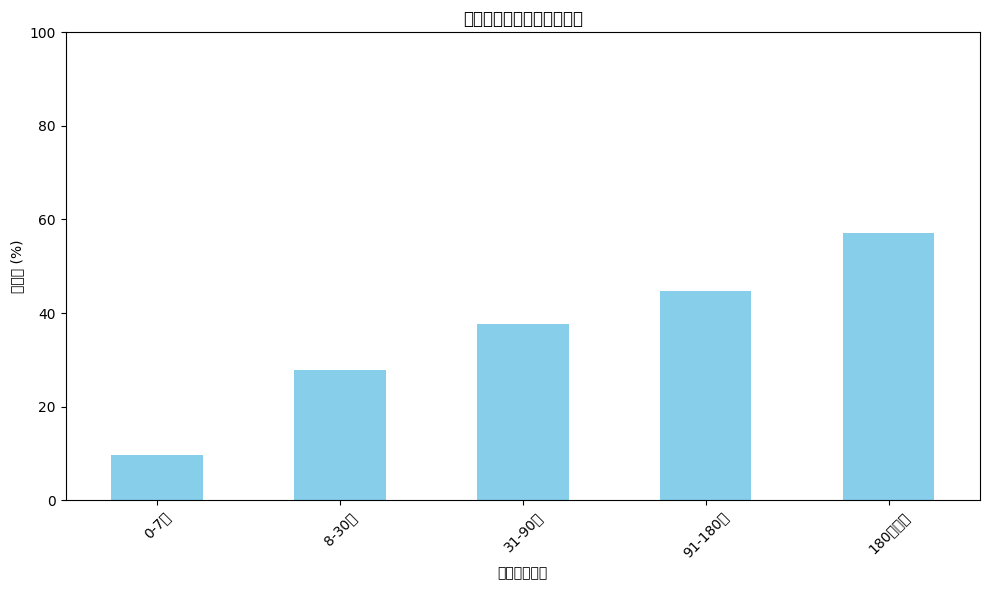

In [8]:
import matplotlib.pyplot as plt
# 将lead_time进行分组
def group_lead_time(lead_time):
    if lead_time <= 7:
        return "0-7天"
    elif lead_time <= 30:
        return "8-30天"
    elif lead_time <= 90:
        return "31-90天"
    elif lead_time <= 180:
        return "91-180天"
    else:
        return "180天以上"

# 添加lead_time分组字段
df['lead_time_group'] = df['lead_time'].apply(group_lead_time)

# 分析各lead_time组的取消率
lead_time_groups = df['lead_time_group'].unique()
for group in sorted(lead_time_groups, key=lambda x: ["0-7天", "8-30天", "31-90天", "91-180天", "180天以上"].index(x)):
    group_df = df[df['lead_time_group'] == group]
    group_canceled = group_df[group_df['is_canceled'] == 1].shape[0]
    group_rate = (group_canceled / len(group_df)) * 100
    print(f"{group} 预订取消率: {group_rate:.2f}%，订单数: {len(group_df)}")

# 卡方检验 - 判断lead_time分组与取消率关系是否显著
contingency_table = pd.crosstab(df['lead_time_group'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"卡方值: {chi2:.4f}")
print(f"p值: {p:.10f}")
print(f"是否显著 (95% 水平): {'显著' if p < 0.05 else '不显著'}")

# 可视化lead_time与取消率的关系
plt.figure(figsize=(10, 6))
group_rates = df.groupby('lead_time_group')['is_canceled'].mean() * 100
group_rates = group_rates.reindex(["0-7天", "8-30天", "31-90天", "91-180天", "180天以上"])
group_rates.plot(kind='bar', color='skyblue')
plt.title('提前预订时长与取消率关系')
plt.xlabel('提前预订时长')
plt.ylabel('取消率 (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('lead_time_cancellation.png')

In [9]:
# 预订修改次数与取消率关系分析
booking_changes = df['booking_changes'].unique()
booking_changes_sorted = sorted(booking_changes)

for changes in booking_changes_sorted:
    changes_df = df[df['booking_changes'] == changes]
    changes_canceled = changes_df[changes_df['is_canceled'] == 1].shape[0]
    changes_rate = (changes_canceled / len(changes_df)) * 100
    print(f"修改 {changes} 次的订单取消率: {changes_rate:.2f}%，订单数: {len(changes_df)}")

# 将修改次数分组，便于分析
def group_booking_changes(changes):
    if changes == 0:
        return "0次"
    elif changes == 1:
        return "1次"
    elif changes <= 3:
        return "2-3次"
    else:
        return "4次及以上"

df['booking_changes_group'] = df['booking_changes'].apply(group_booking_changes)

# 分析各预订修改次数组的取消率
changes_groups = df['booking_changes_group'].unique()
for group in sorted(changes_groups, key=lambda x: ["0次", "1次", "2-3次", "4次及以上"].index(x)):
    group_df = df[df['booking_changes_group'] == group]
    group_canceled = group_df[group_df['is_canceled'] == 1].shape[0]
    group_rate = (group_canceled / len(group_df)) * 100
    print(f"{group} 修改的订单取消率: {group_rate:.2f}%，订单数: {len(group_df)}")

# 卡方检验 - 判断预订修改次数与取消率关系是否显著
contingency_table = pd.crosstab(df['booking_changes_group'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"卡方值: {chi2:.4f}")
print(f"p值: {p:.10f}")
print(f"是否显著 (95% 水平): {'显著' if p < 0.05 else '不显著'}")

修改 0 次的订单取消率: 40.85%，订单数: 101314
修改 1 次的订单取消率: 14.23%，订单数: 12701
修改 2 次的订单取消率: 20.13%，订单数: 3805
修改 3 次的订单取消率: 15.53%，订单数: 927
修改 4 次的订单取消率: 17.82%，订单数: 376
修改 5 次的订单取消率: 16.95%，订单数: 118
修改 6 次的订单取消率: 28.57%，订单数: 63
修改 7 次的订单取消率: 9.68%，订单数: 31
修改 8 次的订单取消率: 23.53%，订单数: 17
修改 9 次的订单取消率: 12.50%，订单数: 8
修改 10 次的订单取消率: 16.67%，订单数: 6
修改 11 次的订单取消率: 0.00%，订单数: 2
修改 12 次的订单取消率: 0.00%，订单数: 2
修改 13 次的订单取消率: 0.00%，订单数: 5
修改 14 次的订单取消率: 20.00%，订单数: 5
修改 15 次的订单取消率: 0.00%，订单数: 3
修改 16 次的订单取消率: 50.00%，订单数: 2
修改 17 次的订单取消率: 0.00%，订单数: 2
修改 18 次的订单取消率: 0.00%，订单数: 1
修改 20 次的订单取消率: 0.00%，订单数: 1
修改 21 次的订单取消率: 0.00%，订单数: 1
0次 修改的订单取消率: 40.85%，订单数: 101314
1次 修改的订单取消率: 14.23%，订单数: 12701
2-3次 修改的订单取消率: 19.23%，订单数: 4732
4次及以上 修改的订单取消率: 18.04%，订单数: 643
卡方值: 4209.4396
p值: 0.0000000000
是否显著 (95% 水平): 显著


In [10]:
import seaborn as sns

# 分销渠道(distribution_channel)维度分析
print("分销渠道(distribution_channel)维度分析")

# 计算每个分销渠道的订单数和取消率
channel_analysis = df.groupby('distribution_channel').agg(
    总订单数=('is_canceled', 'count'),
    取消订单数=('is_canceled', 'sum')
).reset_index()

# 计算取消率和订单占比
channel_analysis['取消率'] = channel_analysis['取消订单数'] / channel_analysis['总订单数'] * 100
channel_analysis['订单占比'] = channel_analysis['总订单数'] / channel_analysis['总订单数'].sum() * 100

# 排序并输出结果
channel_analysis = channel_analysis.sort_values('取消率', ascending=False)
for _, row in channel_analysis.iterrows():
    print(f"{row['distribution_channel']}: 取消率={row['取消率']:.2f}%, "
          f"总订单数={int(row['总订单数'])}({row['订单占比']:.2f}%), "
          f"取消订单数={int(row['取消订单数'])}")

# 卡方检验: 分析分销渠道与取消率的关联性
contingency_table = pd.crosstab(df['distribution_channel'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n 分销渠道卡方检验结果")
print(f"卡方值: {chi2:.2f}")
print(f"p值: {p:.10f}")
print(f"自由度: {dof}")
print(f"显著性: {'是' if p < 0.05 else '否'}")

# 可视化分销渠道取消率
plt.figure(figsize=(10, 6))
sns.barplot(x='distribution_channel', y='取消率', data=channel_analysis)
plt.title('Cancellation Rate by Distribution Channel')
plt.xlabel('分销渠道')
plt.ylabel('取消率(%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('channel_cancellation.png')
plt.close()

# 可视化分销渠道订单占比
plt.figure(figsize=(10, 6))
plt.pie(channel_analysis['总订单数'], labels=channel_analysis['distribution_channel'], 
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Booking Distribution by Channel')
plt.tight_layout()
plt.savefig('channel_distribution.png')
plt.close()

分销渠道(distribution_channel)维度分析
Undefined: 取消率=80.00%, 总订单数=5(0.00%), 取消订单数=4
TA/TO: 取消率=41.03%, 总订单数=97870(81.98%), 取消订单数=40152
Corporate: 取消率=22.08%, 总订单数=6677(5.59%), 取消订单数=1474
GDS: 取消率=19.17%, 总订单数=193(0.16%), 取消订单数=37
Direct: 取消率=17.46%, 总订单数=14645(12.27%), 取消订单数=2557

 分销渠道卡方检验结果
卡方值: 3745.79
p值: 0.0000000000
自由度: 4
显著性: 是


In [11]:
# 市场细分(market_segment)维度分析
print("市场细分(market_segment)维度分析")

# 计算每个市场细分的订单数和取消率
segment_analysis = df.groupby('market_segment').agg(
    总订单数=('is_canceled', 'count'),
    取消订单数=('is_canceled', 'sum')
).reset_index()

# 计算取消率和订单占比
segment_analysis['取消率'] = segment_analysis['取消订单数'] / segment_analysis['总订单数'] * 100
segment_analysis['订单占比'] = segment_analysis['总订单数'] / segment_analysis['总订单数'].sum() * 100

# 排序并输出结果
segment_analysis = segment_analysis.sort_values('取消率', ascending=False)
for _, row in segment_analysis.iterrows():
    print(f"{row['market_segment']}: 取消率={row['取消率']:.2f}%, "
          f"总订单数={int(row['总订单数'])}({row['订单占比']:.2f}%), "
          f"取消订单数={int(row['取消订单数'])}")

# 卡方检验: 分析市场细分与取消率的关联性
contingency_table = pd.crosstab(df['market_segment'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n市场细分卡方检验结果")
print(f"卡方值: {chi2:.2f}")
print(f"p值: {p:.10f}")
print(f"自由度: {dof}")
print(f"显著性: {'是' if p < 0.05 else '否'}")

# 可视化市场细分取消率
plt.figure(figsize=(12, 6))
sns.barplot(x='market_segment', y='取消率', data=segment_analysis)
plt.title('Cancellation Rate by Market Segment')
plt.xlabel('市场细分')
plt.ylabel('取消率(%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('segment_cancellation.png')
plt.close()

# 可视化市场细分订单量与取消率的关系
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(x='订单占比', y='取消率', data=segment_analysis, s=100)
for i, row in segment_analysis.iterrows():
    ax.annotate(row['market_segment'], 
                (row['订单占比'], row['取消率']),
                xytext=(5, 5), textcoords='offset points')
plt.title('Market Segment Cancellation Rate vs Booking Volume')
plt.xlabel('订单占比(%)')
plt.ylabel('取消率(%)')
plt.tight_layout()
plt.savefig('segment_cancellation_volume.png')
plt.close()

市场细分(market_segment)维度分析
Undefined: 取消率=100.00%, 总订单数=2(0.00%), 取消订单数=2
Groups: 取消率=61.06%, 总订单数=19811(16.59%), 取消订单数=12097
Online TA: 取消率=36.72%, 总订单数=56477(47.30%), 取消订单数=20739
Offline TA/TO: 取消率=34.32%, 总订单数=24219(20.29%), 取消订单数=8311
Aviation: 取消率=21.94%, 总订单数=237(0.20%), 取消订单数=52
Corporate: 取消率=18.73%, 总订单数=5295(4.44%), 取消订单数=992
Direct: 取消率=15.34%, 总订单数=12606(10.56%), 取消订单数=1934
Complementary: 取消率=13.06%, 总订单数=743(0.62%), 取消订单数=97

市场细分卡方检验结果
卡方值: 8497.22
p值: 0.0000000000
自由度: 7
显著性: 是


In [12]:
# 房间类型一致性分析
print("房间类型一致性分析")

# 创建房间类型一致性变量
df['room_type_match'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)
df['room_type_consistency'] = df['room_type_match'].map({1: '房型一致', 0: '房型不一致'})

# 计算房间类型一致性的订单数和取消率
room_type_analysis = df.groupby('room_type_consistency').agg(
    总订单数=('is_canceled', 'count'),
    取消订单数=('is_canceled', 'sum')
).reset_index()

# 计算取消率和订单占比
room_type_analysis['取消率'] = room_type_analysis['取消订单数'] / room_type_analysis['总订单数'] * 100
room_type_analysis['订单占比'] = room_type_analysis['总订单数'] / room_type_analysis['总订单数'].sum() * 100

# 排序并输出结果
room_type_analysis = room_type_analysis.sort_values('取消率', ascending=False)
for _, row in room_type_analysis.iterrows():
    print(f"{row['room_type_consistency']}: 取消率={row['取消率']:.2f}%, "
          f"总订单数={int(row['总订单数'])}({row['订单占比']:.2f}%), "
          f"取消订单数={int(row['取消订单数'])}")

# 卡方检验: 分析房间类型一致性与取消率的关联性
contingency_table = pd.crosstab(df['room_type_consistency'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n房间类型一致性卡方检验结果")
print(f"卡方值: {chi2:.2f}")
print(f"p值: {p:.10f}")
print(f"自由度: {dof}")
print(f"显著性: {'是' if p < 0.05 else '否'}")

# 可视化房间类型一致性取消率
plt.figure(figsize=(8, 6))
sns.barplot(x='room_type_consistency', y='取消率', data=room_type_analysis)
plt.title('Cancellation Rate by Room Type Consistency')
plt.xlabel('房间类型一致性')
plt.ylabel('取消率(%)')
plt.tight_layout()
plt.savefig('room_type_cancellation.png')
plt.close()

# 进一步分析房型不一致的情况 - 升级还是降级
df['room_change'] = 'No Change'
# 假设房型编码为字母顺序，A为最好房型
df.loc[(df['room_type_match'] == 0) & 
       (df['assigned_room_type'] < df['reserved_room_type']), 'room_change'] = 'Upgrade'
df.loc[(df['room_type_match'] == 0) & 
       (df['assigned_room_type'] > df['reserved_room_type']), 'room_change'] = 'Downgrade'

# 分析房型变更与取消率关系
room_change_analysis = df.groupby('room_change').agg(
    总订单数=('is_canceled', 'count'),
    取消订单数=('is_canceled', 'sum')
).reset_index()

room_change_analysis['取消率'] = room_change_analysis['取消订单数'] / room_change_analysis['总订单数'] * 100

print("\n===== 房型变更与取消率关系 =====")
print(room_change_analysis)

# 可视化房型变更取消率
plt.figure(figsize=(8, 6))
sns.barplot(x='room_change', y='取消率', data=room_change_analysis)
plt.title('Cancellation Rate by Room Change Type')
plt.xlabel('房型变更类型')
plt.ylabel('取消率(%)')
plt.tight_layout()
plt.savefig('room_change_cancellation.png')
plt.close()

房间类型一致性分析
房型一致: 取消率=41.56%, 总订单数=104473(87.51%), 取消订单数=43422
房型不一致: 取消率=5.38%, 总订单数=14917(12.49%), 取消订单数=802

房间类型一致性卡方检验结果
卡方值: 7327.82
p值: 0.0000000000
自由度: 1
显著性: 是

===== 房型变更与取消率关系 =====
  room_change    总订单数  取消订单数        取消率
0   Downgrade   14277    781   5.470337
1   No Change  104473  43422  41.562892
2     Upgrade     640     21   3.281250


In [13]:
# 押金类型(deposit_type)分析
print("押金类型(deposit_type)分析")

# 计算每种押金类型的订单数和取消率
deposit_analysis = df.groupby('deposit_type').agg(
    总订单数=('is_canceled', 'count'),
    取消订单数=('is_canceled', 'sum')
).reset_index()

# 计算取消率和订单占比
deposit_analysis['取消率'] = deposit_analysis['取消订单数'] / deposit_analysis['总订单数'] * 100
deposit_analysis['订单占比'] = deposit_analysis['总订单数'] / deposit_analysis['总订单数'].sum() * 100

# 排序并输出结果
deposit_analysis = deposit_analysis.sort_values('取消率', ascending=False)
for _, row in deposit_analysis.iterrows():
    print(f"押金类型{row['deposit_type']}: 取消率={row['取消率']:.2f}%, "
          f"总订单数={int(row['总订单数'])}({row['订单占比']:.2f}%), "
          f"取消订单数={int(row['取消订单数'])}")

# 卡方检验: 分析押金类型与取消率的关联性
contingency_table = pd.crosstab(df['deposit_type'], df['is_canceled'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n押金类型卡方检验结果")
print(f"卡方值: {chi2:.2f}")
print(f"p值: {p:.10f}")
print(f"自由度: {dof}")
print(f"显著性: {'是' if p < 0.05 else '否'}")

# 可视化押金类型取消率
plt.figure(figsize=(10, 6))
sns.barplot(x='deposit_type', y='取消率', data=deposit_analysis)
plt.title('Cancellation Rate by Deposit Type')
plt.xlabel('押金类型')
plt.ylabel('取消率(%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('deposit_cancellation.png')
plt.close()

押金类型(deposit_type)分析
押金类型Non Refund: 取消率=99.36%, 总订单数=14587(12.22%), 取消订单数=14494
押金类型No Deposit: 取消率=28.38%, 总订单数=104641(87.65%), 取消订单数=29694
押金类型Refundable: 取消率=22.22%, 总订单数=162(0.14%), 取消订单数=36

押金类型卡方检验结果
卡方值: 27677.33
p值: 0.0000000000
自由度: 2
显著性: 是


In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 决策树模型：识别影响取消率的重要特征
print("\n决策树模型：识别重要特征")

# 准备特征
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
            'adults', 'is_repeated_guest', 'previous_cancellations',
            'previous_bookings_not_canceled', 'booking_changes', 
            'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 
            'total_of_special_requests']

# 将分类变量转换为数值
categorical_features = ['deposit_type', 'customer_type', 'distribution_channel', 
                        'market_segment', 'reserved_room_type', 'assigned_room_type']
categorical_dummies = pd.get_dummies(df[categorical_features], drop_first=False)

# 组合特征
X = pd.concat([df[features], categorical_dummies], axis=1)
y = df['is_canceled']

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练决策树模型
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# 评估模型
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"决策树模型准确率: {accuracy:.4f}")
print("\n分类报告:")
print(report)

# 特征重要性
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n前10个重要特征:")
print(feature_importance.head(10))



决策树模型：识别重要特征
决策树模型准确率: 0.8038

分类报告:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85     22478
           1       0.82      0.61      0.70     13339

    accuracy                           0.80     35817
   macro avg       0.81      0.76      0.78     35817
weighted avg       0.81      0.80      0.80     35817


前10个重要特征:
                           feature  importance
13         deposit_type_Non Refund    0.599319
11       total_of_special_requests    0.121411
30        market_segment_Online TA    0.093568
0                        lead_time    0.089725
5           previous_cancellations    0.080183
6   previous_bookings_not_canceled    0.008660
10     required_car_parking_spaces    0.004076
9                              adr    0.000942
2             stays_in_week_nights    0.000765
7                  booking_changes    0.000721


In [15]:
# 存储不同假设下的全局取消率
results = {}

# 原始全局取消率
original_cancel_rate = (df['is_canceled'].sum() / len(df)) * 100
print(f"原始取消率: {original_cancel_rate:.2f}%")

# 只需要一次模拟，不需要多次循环
df_simulated = df.copy()
target_mask = (df_simulated['lead_time'] > 90) & (df_simulated['deposit_type'] == 'Non Refund')
# 记录受影响的订单数量
affected_orders = target_mask.sum()
print(f"受影响的订单数量: {affected_orders}，占总订单的 {affected_orders/len(df)*100:.2f}%")

# 只修改deposit_type，不修改is_canceled
df_simulated.loc[target_mask, 'deposit_type'] = 'Partial Refund'

# 构建特征
categorical_features = ['deposit_type', 'customer_type', 'distribution_channel', 
                    'market_segment', 'reserved_room_type', 'assigned_room_type']
categorical_encoded_sim = pd.get_dummies(df_simulated[categorical_features], drop_first=False)
X_simulated = pd.concat([df_simulated[features], categorical_encoded_sim], axis=1)

# 对齐特征
X_simulated = X_simulated.reindex(columns=X.columns, fill_value=0)

# 预测并计算取消率
y_pred_simulated = dt_model.predict(X_simulated)
simulated_rate = (y_pred_simulated.sum() / len(y_pred_simulated)) * 100
reduction = original_cancel_rate - simulated_rate

print(f"原始取消率: {original_cancel_rate:.2f}%")
print(f"政策变化后预测取消率: {simulated_rate:.2f}%")
print(f"潜在降幅: {reduction:.2f}%")

原始取消率: 37.04%
受影响的订单数量: 11566，占总订单的 9.69%
原始取消率: 37.04%
政策变化后预测取消率: 20.70%
潜在降幅: 16.34%


In [16]:
# 存储不同假设下的全局取消率
results = {}

# 原始全局取消率
original_cancel_rate = (df['is_canceled'].sum() / len(df)) * 100
print(f"原始取消率: {original_cancel_rate:.2f}%")

assumed_rates = [0.9, 0.6, 0.4]  # 保守/中性/乐观情景  
# 对于每个假设的取消率
for rate in assumed_rates:
    # 创建数据副本
    df_modified = df.copy()
    
    # 标识目标订单
    target_mask = (df_modified['lead_time'] > 90) & (df_modified['deposit_type'] == 'Non Refund')
    affected_orders = target_mask.sum()
    
    # 根据假设调整deposit_type和is_canceled
    df_modified.loc[target_mask, 'deposit_type'] = 'Partial Refund'
    df_modified.loc[target_mask, 'is_canceled'] = np.random.choice([0,1], size=affected_orders, p=[1-rate, rate])
    
    # 使用修改后的数据重新训练模型
    X_modified = pd.concat([df_modified[features], 
                           pd.get_dummies(df_modified[categorical_features], drop_first=False)], 
                          axis=1)
    y_modified = df_modified['is_canceled']
    
    # 分割训练集和测试集
    X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(X_modified, y_modified, 
                                                                      test_size=0.3, random_state=42)
    
    # 训练新模型
    dt_model_mod = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt_model_mod.fit(X_train_mod, y_train_mod)
    
    # 在测试集上评估
    y_pred_mod = dt_model_mod.predict(X_test_mod)
    modified_cancel_rate = (y_pred_mod.sum() / len(y_pred_mod)) * 100
    
    results[f"取消率_{rate*100:.0f}%"] = modified_cancel_rate
    
    print(f"假设取消率 {rate*100:.0f}%:")
    print(f"  - 模型预测取消率: {modified_cancel_rate:.2f}%")
    print(f"  - 与原始取消率差异: {modified_cancel_rate - original_cancel_rate:.2f}%")

原始取消率: 37.04%
假设取消率 90%:
  - 模型预测取消率: 27.81%
  - 与原始取消率差异: -9.23%
假设取消率 60%:
  - 模型预测取消率: 27.78%
  - 与原始取消率差异: -9.26%
假设取消率 40%:
  - 模型预测取消率: 19.37%
  - 与原始取消率差异: -17.67%
